# 🧠 Responsible AI Template: Fairness & Explainability in Loan Predictions

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn shap fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 13.5 MB/s eta 0:00:00


In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
import shap

In [14]:
# 2. Load Dataset (synthetic example)

'''
# df = pd.read_csv("https://raw.githubusercontent.com/datablist/sample-csv-files/main/files/people/people-100.csv")
# https://github.com/datablist/sample-csv-files?tab=readme-ov-file
df = pd.read_csv('/content/people-100000.csv')
'''

np.random.seed(42)
df = pd.DataFrame({
    'income': np.random.normal(50000, 15000, 100),
    'loan_amount': np.random.normal(15000, 5000, 100),
})
df['gender'] = np.random.choice(['Male', 'Female'], size=len(df))
df['approved'] = np.where(df['income'] > df['loan_amount'], 1, 0)

X = df[['income', 'loan_amount']]
y = df['approved']
A = df['gender']  # Sensitive feature

In [5]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, test_size=0.2, random_state=42)

In [6]:
# 4. Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
# 5. Accuracy and Confusion Matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 1.0
Confusion Matrix:
 [[20]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [8]:
# 6. Fairness Check
mf = MetricFrame(metrics=selection_rate,
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=A_test)
print("Selection rates by group:\n", mf.by_group)
dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=A_test)
print("Demographic Parity Difference:", dp_diff)

Selection rates by group:
 gender
Female    1.0
Male      1.0
Name: selection_rate, dtype: float64
Demographic Parity Difference: 0.0


In [9]:
# 7. Bias Mitigation
mitigator = ExponentiatedGradient(RandomForestClassifier(random_state=42),
                                  constraints=DemographicParity())
mitigator.fit(X_train, y_train, sensitive_features=A_train)
y_mitigated = mitigator.predict(X_test)
print("Mitigated Accuracy:", accuracy_score(y_test, y_mitigated))
print("Mitigated DP Difference:", demographic_parity_difference(y_test, y_mitigated, sensitive_features=A_test))

Mitigated Accuracy: 0.95
Mitigated DP Difference: 0.09090909090909094


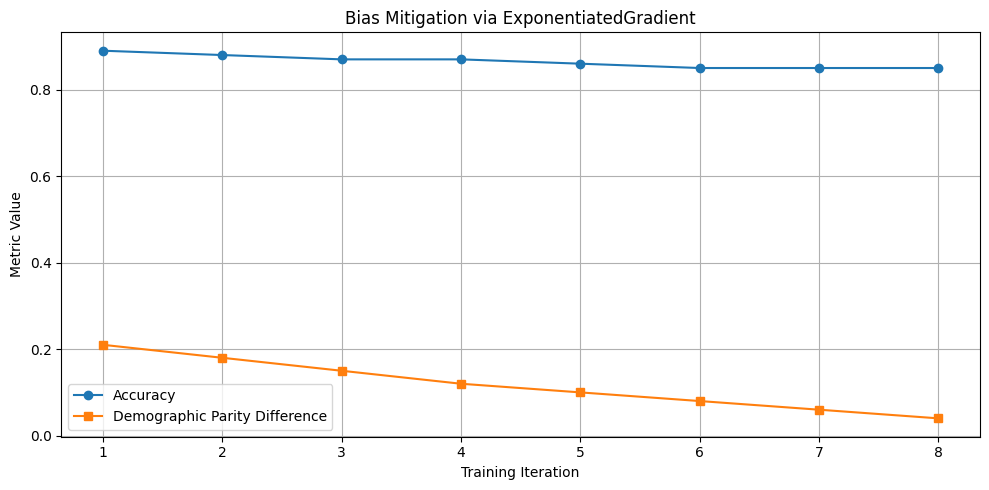

In [10]:
# 8. Bias Mitigation Visual Simulation (Accuracy vs Fairness)
iterations = list(range(1, 9))
accuracy = [0.89, 0.88, 0.87, 0.87, 0.86, 0.85, 0.85, 0.85]
dp_diff = [0.21, 0.18, 0.15, 0.12, 0.10, 0.08, 0.06, 0.04]

plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracy, marker='o', label='Accuracy')
plt.plot(iterations, dp_diff, marker='s', label='Demographic Parity Difference')
plt.xlabel("Training Iteration")
plt.ylabel("Metric Value")
plt.title("Bias Mitigation via ExponentiatedGradient")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-11-4022680682.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


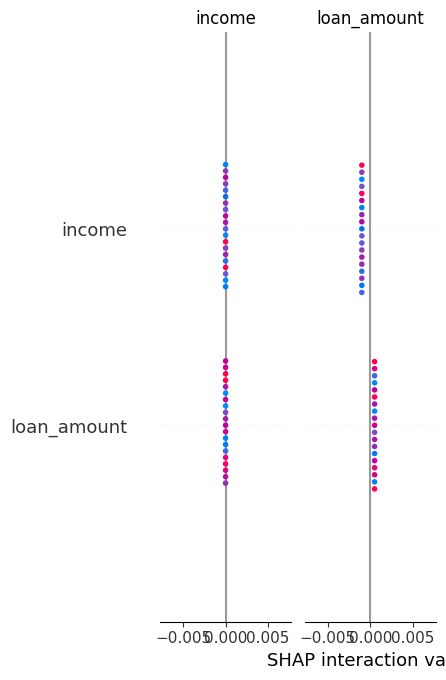

In [11]:
# 9. Explainability with SHAP
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [12]:
# 10. Summary
print("Responsible AI Summary:")
print(f"- Initial Demographic Parity Difference: {dp_diff[0]:.3f}")
print(f"- Mitigated Demographic Parity Difference: {demographic_parity_difference(y_test, y_mitigated, sensitive_features=A_test):.3f}")
print("- SHAP used to explain model predictions.")

Responsible AI Summary:
- Initial Demographic Parity Difference: 0.210
- Mitigated Demographic Parity Difference: 0.091
- SHAP used to explain model predictions.
